In [8]:
from gcm import GCM
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

## Step 0: Functions

In [9]:
def scatter(df, columns):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(df[columns[0]], df[columns[1]], alpha=0.5)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_title(f"Scatter plot of {columns[0]} vs {columns[1]}")
    plt.show()

In [ ]:
def compute_multipole(df: pd.DataFrame, columns: list, method="pearson"):
    corr_matrix = df[columns].corr(method=method)
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    multipole = 1 - min(eigenvalues)
    return multipole

# Step 1: Load Data

In [10]:
df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv", nrows = 5000)
numeric_df = df.select_dtypes(include="number")
numeric_df = numeric_df.dropna(axis=1).iloc[:,2:]  # Drop columns with NaNs

columns_to_drop = ['policy_code', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths','delinq_amnt', 'tax_liens','pub_rec_bankruptcies']
numeric_df = numeric_df.drop(columns=columns_to_drop)
rename_map = {
    # Scenario 1
    'all_util': 'utilization_ratio',
    'tot_cur_bal': 'total_current_balance',
    'last_fico_range_low': 'fico_score_low',

    # Scenario 2
    'mort_acc': 'mortgage_accounts',
    'tot_hi_cred_lim': 'total_credit_limit',
    'total_bal_ex_mort': 'balance_excl_mortgage',

    # Scenario 3
    'num_rev_accts': 'revolving_accounts',
    'num_accts_ever_120_pd': 'ever_120dpd_accounts',

    # Scenario 4
    'delinq_2yrs': 'delinquencies_2yrs',
    'pub_rec': 'public_records',
    'collection_recovery_fee': 'recovery_fee'
}

numeric_df = numeric_df.rename(columns=rename_map)



/tmp/ipykernel_11381/2072445100.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv", nrows = 5000)


In [11]:
# plot data, exploratory plot

numeric_df.head()


,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinquencies_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,total_credit_limit,balance_excl_mortgage,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,...,4.0,7.0,0.0,0.0,3.0,76.9,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,...,5.0,22.0,0.0,0.0,2.0,97.4,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,...,3.0,6.0,0.0,0.0,0.0,100.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,0.0,...,5.0,13.0,0.0,0.0,1.0,100.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,...,6.0,12.0,0.0,0.0,4.0,96.6,439570.0,95768.0,20300.0,88097.0


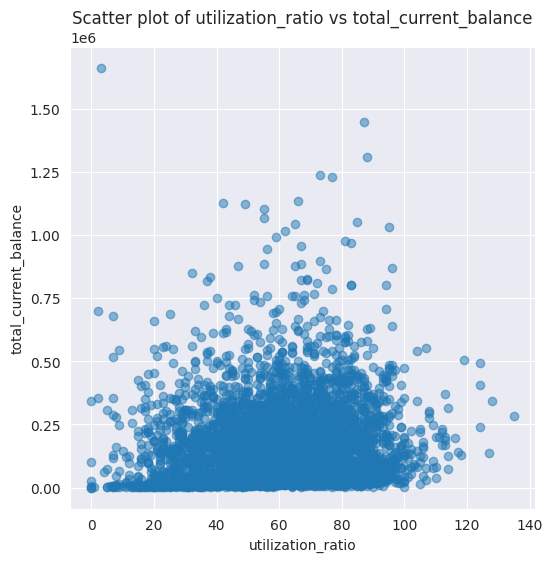

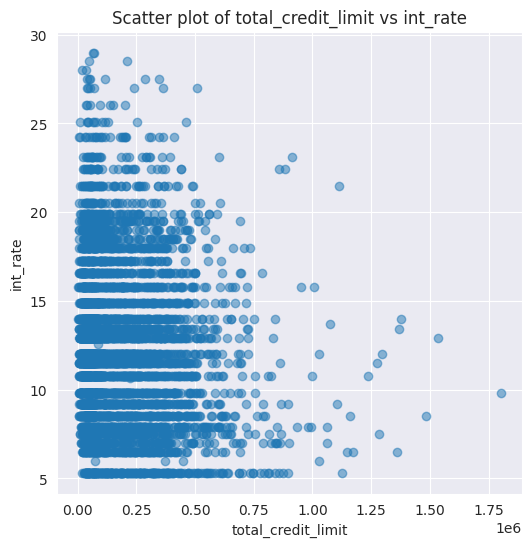

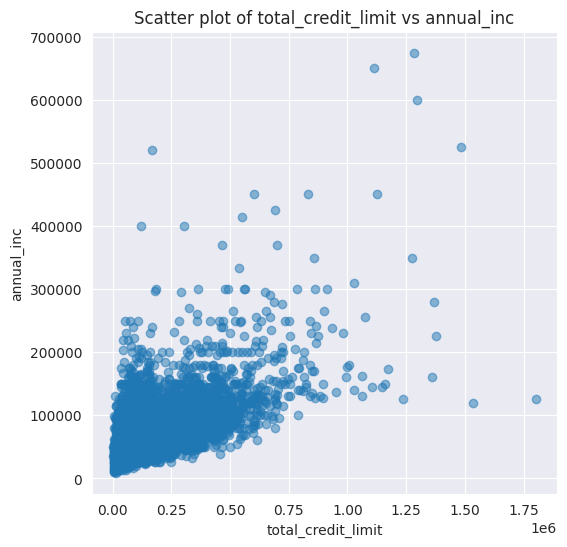

In [37]:
scatter(numeric_df, ['utilization_ratio','total_current_balance'])
scatter(numeric_df, ['total_credit_limit','int_rate'])
scatter(numeric_df, ['total_credit_limit','annual_inc'])



# Step 2: Check Correlations

In [52]:
s1 = ['mortgage_accounts','total_credit_limit','balance_excl_mortgage']
s2 = ['delinquencies_2yrs','total_current_balance','recovery_fee']
s3 = ['total_credit_limit','int_rate', 'annual_inc']
scenarios = [s1, s2, s3]
scenarios_dict = {i: {'columns': s, 'Original Multipole': None, 'Synthetic Multipole': None} for i, s in enumerate(scenarios)}


In [56]:
# pairwise correlations:

for i, s in enumerate(scenarios):
    corr_matrix = numeric_df[s].corr(method='pearson')

    print("Pairwise correlation matrix")
    display(corr_matrix)
    multipole_val = compute_multipole(numeric_df, s, method="pearson")
    scenarios_dict[i]['Original Multipole'] = multipole_val
    print(f"Columns: {s}, Multipole: {multipole_val:.4f}")
    print("\n")

Pairwise correlation matrix


,mortgage_accounts,total_credit_limit,balance_excl_mortgage
mortgage_accounts,1.000000,0.550073,0.132980
total_credit_limit,0.550073,1.000000,0.493341
balance_excl_mortgage,0.132980,0.493341,1.000000


Columns: ['mortgage_accounts', 'total_credit_limit', 'balance_excl_mortgage'], Multipole: 0.6759


Pairwise correlation matrix


,delinquencies_2yrs,total_current_balance,recovery_fee
delinquencies_2yrs,1.000000,0.048341,-0.001359
total_current_balance,0.048341,1.000000,0.004691
recovery_fee,-0.001359,0.004691,1.000000


Columns: ['delinquencies_2yrs', 'total_current_balance', 'recovery_fee'], Multipole: 0.0487


Pairwise correlation matrix


,total_credit_limit,int_rate,annual_inc
total_credit_limit,1.000000,-0.130139,0.578753
int_rate,-0.130139,1.000000,-0.114495
annual_inc,0.578753,-0.114495,1.000000


Columns: ['total_credit_limit', 'int_rate', 'annual_inc'], Multipole: 0.5790




In [5]:
# column namen duidelijker maken, intuitief.

# Step 3: Fit GCM and Generate Synthetic Data

In [7]:
# 1. Initialize the GCM model and fit it to your source data
gcm = GCM()
gcm.fit(numeric_df)

# # 2. Generate synthetic samples
synthetic_data = gcm.sample(num_samples=50000)

# 3. Verify that the correlation structure is preserved
corr_real = np.corrcoef(numeric_df, rowvar=False)
corr_synth = np.corrcoef(synthetic_data, rowvar=False)

# show rows of synth data.

array([ 1.        ,  0.99999841,  0.17091589,  0.94564572,  0.41698277,
        0.04726463, -0.06939867,  0.10797672,  0.10796517, -0.03033318,
        0.20225204, -0.07963908,  0.3399029 ,  0.19414187,  0.29761441,
        0.29761635,  0.88699292,  0.88697695,  0.79020401,  0.67952745,
        0.07157646,  0.15017917,  0.14632613,  0.42166783,  0.07931069,
        0.06161401,  0.00975918, -0.01311932,  0.29207306, -0.05547857,
        0.0396778 , -0.0108493 ,  0.01905046,  0.11945614, -0.03203222,
       -0.00710426,  0.42139094,  0.04623049,  0.35107679,  0.01888505,
        0.06741984,  0.01979331,  0.01647783,  0.18993002,  0.15209601,
        0.04893452,  0.04022157,  0.19711639, -0.06366276,  0.21561225,
        0.1771427 ,  0.23544501,  0.20330672,  0.06872543,  0.18420463,
        0.17092818,  0.17604073,  0.20196105,  0.01588533, -0.07494872,
       -0.02353958,  0.1382456 ,  0.3218413 ,  0.25256628,  0.37199513,
        0.17832054])

# Step 4: Validate Results

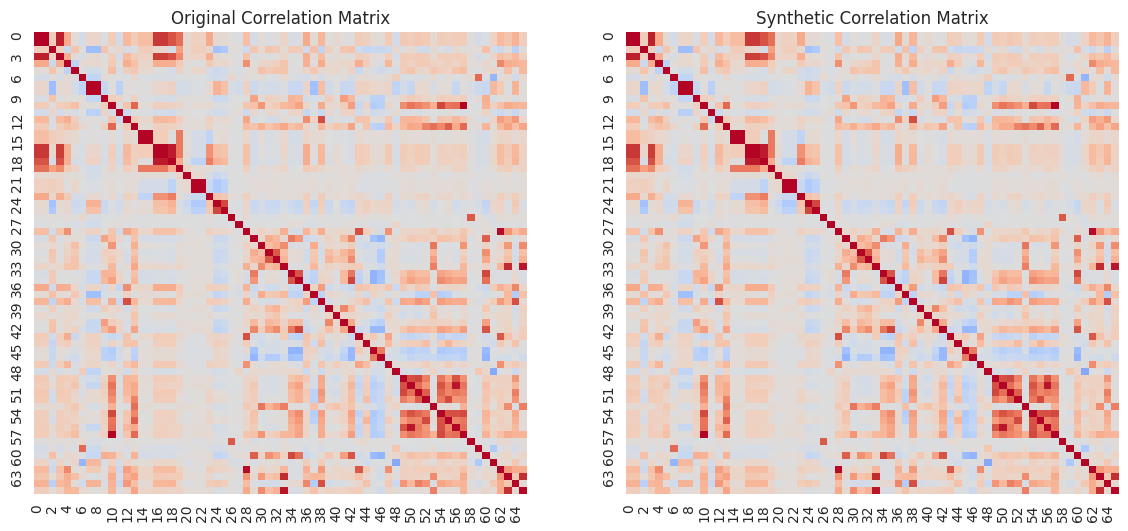

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("Original Correlation Matrix")

sns.heatmap(corr_synth, ax=axes[1], cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("Synthetic Correlation Matrix")

plt.show()


In [7]:
# Are the multipoles preserved?
for i, s in enumerate(scenarios):
    scenarios_dict[i]['Synthetic Multipole'] = compute_multipole(pd.DataFrame(synthetic_data, columns=numeric_df.columns), s, method="pearson")
    
# Convert to DataFrame
df = pd.DataFrame.from_dict(scenarios_dict, orient='index')

# Format numeric columns nicely
numeric_cols = ['Original Multipole', 'Synthetic Multipole']
df[numeric_cols] = df[numeric_cols].applymap(lambda x: f"{x:.4f}" if x is not None else "-")
display(df)


,columns,Original Multipole,Synthetic Multipole
0,"[all_util, tot_cur_bal, last_fico_range_low]",0.2170,0.2147
1,"[mort_acc, tot_hi_cred_lim, total_bal_ex_mort]",0.6759,0.6780
2,"[num_rev_accts, all_util, num_accts_ever_120_pd]",0.2448,0.2402
3,"[delinq_2yrs, pub_rec, collection_recovery_fee]",0.0029,0.0065


In [8]:
# conclusie

In [ ]:
# voorbeeldgebruik van de data.
# applicaties
- privacy
 # synth row, check of hij in de originele zit of niet
 # linear regressie: fico predicted door inkomen oid, is het beter met synth data (meer data) dan met de 5000 originele rijen
 # zelfde voor 'data hungry' model als random forest, xgboost, nn
 # originele split in train en test. Generatie alleen op de train. Error op de test.
 